# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [1]:
!apt-get update && apt-get install -y python3-opencv

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease                
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease       
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done                    
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.


In [2]:
!pip install sklearn

In [3]:
!pip install pandas

In [4]:
!pip install wandb

In [5]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import albumentations as A # augmentation을 위한 라이브러리(pytorch.transform보다 속도가 4배 빠르다)
import albumentations.pytorch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

In [6]:
# import wandb
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: juyeonn (use `wandb login --relogin` to force relogin)


True

## Set Arguments & hyperparameters

In [7]:
# 시드(seed) 설정
# 실험을 동일하게 진행하기 위해서 동일한 난수의 사용이 필요 -> 시드 고정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED) # random seed를 고정하기 위한 함수 

# Nondeterministic 한 작업 피하기
# Nondeterministic = 비결정론적 = 동일한 입력이 주어지더라도 매번 다른 과정을 거쳐 다른 결과를 도출
# cudnn = 딥러닝에 특화된 CUDA library
torch.backends.cudnn.deterministic = True # Deterministic 한 알고리즘만 사용 # Deterministic = 결정론적 =  어떤 입력이 들어오면 언제나 똑같은 과정을 거쳐서 언제나 똑같은 결과
# cudnn은 convolution을 수행하는 과정에 벤치마킹을 통해서 지금 환경에 가장 적합한 알고리즘을 선정해 수행한다고 함,
# 이 과정에서 다른 알고리즘이 선정되면 연산 후 값이 달라질 수 있기 때문에 False로 설정
torch.backends.cudnn.benchmark = False 
np.random.seed(RANDOM_SEED) # 넘파이 시드 고정
random.seed(RANDOM_SEED)

In [8]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2 # binary classification

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 50
INPUT_SHAPE = 256


os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0번 gpu 사용 (특정 gpu 지정)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device에 cuda (GPU)를 설정

In [9]:
# wandb config 모델의 하이퍼파라미터, 데이터명 등 학습에 필요한 구성들을 그룹화
config = {
    'epochs': 100,
    'classes': 2,
    'batch_size': 32,
    'learning late': 0.0005, # 3배씩 늘린다 0.001
    'early_stopping_patience': 50,
    'input_shape': 256,
    'architecture': 'GoogLeNet'
}

## Dataloader

#### Train & Validation Set loader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        # 이미지를 input_shape로 Resize하고, Tensor화, Normalize하는 함수 
        
        # Albumentation 적용전
         '''
            if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30)
                ]),
                transforms.Resize(self.input_shape),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]) 
        elif self.mode == 'val':
            self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        else:
            print(f'!!! Invalid transform {self.mode}... !!!')
            '''
        
        # Albumentation 적용후
        # RandomHorizontalFlip, RandomVerticalFlip 과 같은 augmentation은 CT사진에는 성능개선에 크게 영향을 주지 못하였기 때문에 제외 시킨후
        # CLAHE, Blur, Cutout등 다른 요소들을 고려하여 Albumentation으로 augmentation을 진행하였더니 속도도 더 빠르고, 모델 성능도 올라가게 되었다.
        if self.mode == 'train':
            self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.OneOf([
                                        A.Blur(blur_limit=7, always_apply=False, p=0.5),
                                        A.CLAHE(clip_limit=5.0, always_apply=False, p=0.5),
                                    ],p=0.5),
                                    A.OneOf([
                                        A.Cutout(num_holes=8, max_h_size=15, max_w_size=15, fill_value=0, always_apply=False, p=0.5),
                                        A.Rotate(always_apply=False, p=0.5),
                                        A.ToSepia(always_apply=False, p=0.5)
                                    ],p=0.5),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])
           
            
        elif self.mode == 'val':
            self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])
        else:
            print(f'!!! Invalid transform {self.mode}... !!!')
 

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir): # 폴더가 없으면 
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit() # 프로그램 중단 
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv')) # os.path.join() = 인수에 전달된 2개의 문자열을 결합하여, 1개의 경로로 만드는 함수 
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index): # 각 데이터의 이미지 텐서, 라벨값 리턴
        data = copy.deepcopy(self.db.loc[index]) # db의 index row를 깊은 복사 

        # Loading image
        # cv2.imread(filename, flag) = 이미지 읽어오는 함수 filename: 이미지 경로, flag: 이미지 파일 읽을 때 option -> return type: numpy.ndarray
        # cv2.IMREAD_COLOR: 이미지 파일을 Color로 읽어들임, 투명한 부분은 무시
        # cv2.IMREAD_IGNORE_ORIENTATION: EXIF에 저장된 방향 정보를 사용하지 않음
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray): # cvimg의 np.ndarray가 int형이 아니면 
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images 이미지 전처리 
        transformed = self.transform(image=cvimg)
        trans_image = transformed["image"]


        return trans_image, data['COVID']


## Model

In [12]:
#import torch.nn.functional as F

In [13]:
#Model 정의
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        self.model = models.googlenet(pretrained=False, aux_logits=False) # AttributeError:  'GoogLeNetOutputs' object has no attribute 'softmax'에러가 발생하여 aux_logits=False로 해결
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1) 

    
    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

## Utils
### EarlyStopper

In [14]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [15]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer # 최적화 
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader): # enumerate: 인덱스와 값이 함께 출력 
            img = img.to(self.device) # gpu에 올리기
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad() # gradients를 zero로 만들어줌 
            loss.backward() #  gradient 계산, 역전파 단계 
            self.optimizer.step() # 매개변수 갱신
            self.scheduler.step() # 학습률 스케쥴러 학습과정에서 learning rate를 조정하는 learning rate scheduler
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist()) # iterable 자료형의 항목 각각을 array의 끝에 하나씩 추가 
                                                      # iterable: member를 하나씩 차례로 반환 가능한 object, 예로는 list, str, tuple 
                                                      # cpu(): GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사하는 method
                                                      
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist()) # argmax: arguments of the maxima 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수 
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [17]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [19]:
# 이미지를 보여주는 함수
def show_batch(image):
    for images, labels in image:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


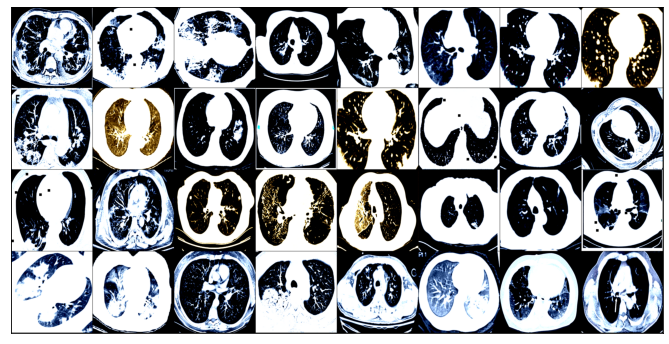

In [20]:
show_batch(train_dataloader)

#### Load model and other utils

In [21]:
# Load Model
model = GoogLeNet(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# OneCycleLR: 초기 learing rate에서 1cycle annealing하는 scheduler
# 1주기 전략은 초기 learning rate에서 최대 learning rate까지 올라간 후 초기 learning rate보다 훨씬 낮은 learning rate로 annealing함 
# pct_start: learning rate를 언제까지 증가시킬지 epoch에 대한 비율로 나타냄
# div_factor: initial_lr = max_lr/div_factor 로 lr 초기화 
# max_lr: 최대 lr
# steps_per_epoch: epoch당 step수
scheduler =  optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
# BCELoss에서는 CrossEntropyLoss와 같이 softmax를 포함한 것이 아닌, Cross Entropy만 구함
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

/opt/conda/lib/python3.8/site-packages/torchvision/models/googlenet.py:71: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


In [22]:
model

GoogLeNet(
  (model): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): B

### epoch 단위 학습 진행

In [23]:
# wandb.init(project='Image Augmentation', name='GoogLeNet_aug+', config=config)
# wandb.watch(model, metric_fn, log='all', log_freq=10)

# tqdm: 진행상황을 제공하는 라이브러리
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)
    
    # wandb.log({"train_loss": trainer.train_mean_loss}, step=epoch_index)
    # wandb.log({"train_score": trainer.train_score}, step=epoch_index)
    # wandb.log({"val_loss": trainer.val_mean_loss}, step=epoch_index)
    # wandb.log({"val_score": trainer.validation_score}, step=epoch_index)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(), # 모델의 실제 내용 (가중치, 양자화 방법, 옵티마이저 등)을 저장
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')

# wandb.finish()

  0% 0/100 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7499755124251047, Acc: 0.5060240963855421, F1-Macro: 0.41795556486377994


  1% 1/100 [00:24<41:06, 24.91s/it]

Epoch 0, Val loss: 1.0195680558681488, Acc: 0.5076923076923077, F1-Macro: 0.336734693877551
Epoch 1, Train loss: 0.7201056943999397, Acc: 0.5352839931153184, F1-Macro: 0.4646805896805897


  2% 2/100 [00:49<40:42, 24.92s/it]

Epoch 1, Val loss: 1.0205411612987518, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/50
Epoch 2, Train loss: 0.667271700170305, Acc: 0.6471600688468159, F1-Macro: 0.6363883368288654
Epoch 2, Val loss: 0.8984079584479332, Acc: 0.5076923076923077, F1-Macro: 0.336734693877551
Validation loss decreased 1.0195680558681488 -> 0.8984079584479332


  3% 3/100 [01:15<40:47, 25.23s/it]

Epoch 3, Train loss: 0.6391357448365953, Acc: 0.6592082616179001, F1-Macro: 0.6567669172932331
Epoch 3, Val loss: 1.0970030426979065, Acc: 0.676923076923077, F1-Macro: 0.675694939415538
Early stopping counter 1/50


  4% 4/100 [01:42<41:01, 25.64s/it]

Epoch 4, Train loss: 0.5740668094820447, Acc: 0.7194492254733219, F1-Macro: 0.7175211852399801
Epoch 4, Val loss: 1.073778748512268, Acc: 0.6615384615384615, F1-Macro: 0.6474358974358974
Early stopping counter 2/50


  5% 5/100 [02:11<42:22, 26.77s/it]

Epoch 5, Train loss: 0.5796348634693358, Acc: 0.7039586919104991, F1-Macro: 0.7030005468508524
Epoch 5, Val loss: 0.8685396602377295, Acc: 0.6615384615384615, F1-Macro: 0.6299171842650102
Validation loss decreased 0.8984079584479332 -> 0.8685396602377295


  6% 6/100 [02:38<41:44, 26.65s/it]

Epoch 6, Train loss: 0.5893033925029967, Acc: 0.7314974182444062, F1-Macro: 0.7288879848764029
Epoch 6, Val loss: 0.6462420485913754, Acc: 0.7076923076923077, F1-Macro: 0.7074153044302298
Validation loss decreased 0.8685396602377295 -> 0.6462420485913754


  7% 7/100 [03:04<41:08, 26.54s/it]

Epoch 7, Train loss: 0.5493849060601659, Acc: 0.7314974182444062, F1-Macro: 0.728699712643678
Epoch 7, Val loss: 2.0783014595508575, Acc: 0.5230769230769231, F1-Macro: 0.41441441441441446
Early stopping counter 1/50


  8% 8/100 [03:31<40:57, 26.71s/it]

Epoch 8, Train loss: 0.5643716835313373, Acc: 0.7349397590361446, F1-Macro: 0.7336131951887579
Epoch 8, Val loss: 1.6790823936462402, Acc: 0.6307692307692307, F1-Macro: 0.577922077922078
Early stopping counter 2/50


  9% 9/100 [03:57<39:59, 26.37s/it]

Epoch 9, Train loss: 0.5736780083841748, Acc: 0.7142857142857143, F1-Macro: 0.7083333333333333
Epoch 9, Val loss: 1.325559314340353, Acc: 0.6615384615384615, F1-Macro: 0.6366869918699187
Early stopping counter 3/50


 10% 10/100 [04:25<40:18, 26.87s/it]

Epoch 10, Train loss: 0.5412010302146276, Acc: 0.7693631669535284, F1-Macro: 0.7672776621948012
Epoch 10, Val loss: 1.0605607330799103, Acc: 0.5384615384615384, F1-Macro: 0.4422196796338673
Early stopping counter 4/50


 11% 11/100 [04:51<39:30, 26.64s/it]

Epoch 11, Train loss: 0.5465902719232771, Acc: 0.7641996557659209, F1-Macro: 0.7634821728368649
Epoch 11, Val loss: 0.9235511720180511, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333333
Early stopping counter 5/50


 12% 12/100 [05:16<38:24, 26.19s/it]

Epoch 12, Train loss: 0.512110013100836, Acc: 0.7762478485370051, F1-Macro: 0.7750154894671623
Epoch 12, Val loss: 0.8122935891151428, Acc: 0.7230769230769231, F1-Macro: 0.7214285714285714
Early stopping counter 6/50


 13% 13/100 [05:43<38:34, 26.60s/it]

Epoch 13, Train loss: 0.49038948118686676, Acc: 0.7814113597246127, F1-Macro: 0.7799091443280826
Epoch 13, Val loss: 0.6834511682391167, Acc: 0.5692307692307692, F1-Macro: 0.5666666666666667
Early stopping counter 7/50


 14% 14/100 [06:11<38:27, 26.83s/it]

Epoch 14, Train loss: 0.45434312025705975, Acc: 0.7951807228915663, F1-Macro: 0.7916150519161506
Epoch 14, Val loss: 0.9826778769493103, Acc: 0.6923076923076923, F1-Macro: 0.6916508538899431
Early stopping counter 8/50


 15% 15/100 [06:39<38:45, 27.36s/it]

Epoch 15, Train loss: 0.4432423561811447, Acc: 0.8227194492254734, F1-Macro: 0.8217881636822246
Epoch 15, Val loss: 0.9010930955410004, Acc: 0.6923076923076923, F1-Macro: 0.6916508538899431
Early stopping counter 9/50


 16% 16/100 [07:07<38:32, 27.53s/it]

Epoch 16, Train loss: 0.4351535596781307, Acc: 0.8141135972461274, F1-Macro: 0.8139543158044545
Epoch 16, Val loss: 0.6807420421391726, Acc: 0.6923076923076923, F1-Macro: 0.6886973180076628
Early stopping counter 10/50


 17% 17/100 [07:35<37:57, 27.44s/it]

Epoch 17, Train loss: 0.3695835914048884, Acc: 0.846815834767642, F1-Macro: 0.845763101143302
Epoch 17, Val loss: 1.4137142896652222, Acc: 0.7538461538461538, F1-Macro: 0.74
Early stopping counter 11/50


 18% 18/100 [08:01<37:07, 27.17s/it]

Epoch 18, Train loss: 0.40354785074790317, Acc: 0.8209982788296041, F1-Macro: 0.8194962240703566
Epoch 18, Val loss: 0.7018851186148822, Acc: 0.676923076923077, F1-Macro: 0.656084656084656
Early stopping counter 12/50


 19% 19/100 [08:27<36:17, 26.89s/it]

Epoch 19, Train loss: 0.3713937567340003, Acc: 0.846815834767642, F1-Macro: 0.8462894427847386
Epoch 19, Val loss: 0.9541209004819393, Acc: 0.6461538461538462, F1-Macro: 0.6458185264155414
Early stopping counter 13/50


 20% 20/100 [08:55<36:02, 27.03s/it]

Epoch 20, Train loss: 0.4190882411268022, Acc: 0.8364888123924269, F1-Macro: 0.8350640230692226
Epoch 20, Val loss: 1.8085289597511292, Acc: 0.5076923076923077, F1-Macro: 0.3627450980392157
Early stopping counter 14/50


 21% 21/100 [09:23<35:55, 27.29s/it]

Epoch 21, Train loss: 0.4993610108892123, Acc: 0.7710843373493976, F1-Macro: 0.7698818035896686
Epoch 21, Val loss: 2.0934038013219833, Acc: 0.6615384615384615, F1-Macro: 0.6425000000000001
Early stopping counter 15/50


 22% 22/100 [09:50<35:36, 27.39s/it]

Epoch 22, Train loss: 0.4713180214166641, Acc: 0.8003442340791739, F1-Macro: 0.7986688653092439
Epoch 22, Val loss: 1.191918846219778, Acc: 0.5846153846153846, F1-Macro: 0.5830363506771205
Early stopping counter 16/50


 23% 23/100 [10:18<35:17, 27.50s/it]

Epoch 23, Train loss: 0.5122662054167854, Acc: 0.7555938037865749, F1-Macro: 0.754370608550673
Epoch 23, Val loss: 1.2433051187545061, Acc: 0.5538461538461539, F1-Macro: 0.45219412961348443
Early stopping counter 17/50


 24% 24/100 [10:45<34:47, 27.47s/it]

Epoch 24, Train loss: 0.4743514127201504, Acc: 0.774526678141136, F1-Macro: 0.772561968653349
Epoch 24, Val loss: 0.7696742676198483, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 18/50


 25% 25/100 [11:15<35:08, 28.12s/it]

Epoch 25, Train loss: 0.41617782910664874, Acc: 0.8209982788296041, F1-Macro: 0.8202693698838759
Epoch 25, Val loss: 0.4817627677693963, Acc: 0.8, F1-Macro: 0.7969238163902908
Validation loss decreased 0.6462420485913754 -> 0.4817627677693963


 26% 26/100 [11:42<34:17, 27.80s/it]

Epoch 26, Train loss: 0.4126659250921673, Acc: 0.8399311531841652, F1-Macro: 0.8383199131051446
Epoch 26, Val loss: 0.6287296637892723, Acc: 0.7076923076923077, F1-Macro: 0.7076923076923077
Early stopping counter 1/50


 27% 27/100 [12:10<33:58, 27.93s/it]

Epoch 27, Train loss: 0.41530565669139224, Acc: 0.8296041308089501, F1-Macro: 0.8287926277157169
Epoch 27, Val loss: 0.5348832309246063, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333334
Early stopping counter 2/50


 28% 28/100 [12:38<33:24, 27.84s/it]

Epoch 28, Train loss: 0.40828008784188163, Acc: 0.8244406196213425, F1-Macro: 0.8241149654533798
Epoch 28, Val loss: 2.3504458656534553, Acc: 0.5230769230769231, F1-Macro: 0.39398496240601505
Early stopping counter 3/50


 29% 29/100 [13:05<32:35, 27.55s/it]

Epoch 29, Train loss: 0.3985358575979869, Acc: 0.8485370051635112, F1-Macro: 0.8468487898394441
Epoch 29, Val loss: 1.009480208158493, Acc: 0.7538461538461538, F1-Macro: 0.749034749034749
Early stopping counter 4/50


 30% 30/100 [13:34<32:33, 27.90s/it]

Epoch 30, Train loss: 0.36837156034178203, Acc: 0.8605851979345955, F1-Macro: 0.859921240858314
Epoch 30, Val loss: 0.7307131662964821, Acc: 0.7076923076923077, F1-Macro: 0.7006060606060607
Early stopping counter 5/50


 31% 31/100 [14:00<31:43, 27.59s/it]

Epoch 31, Train loss: 0.33066462104519206, Acc: 0.8760757314974182, F1-Macro: 0.8754555198285101
Epoch 31, Val loss: 2.4877278208732605, Acc: 0.7230769230769231, F1-Macro: 0.7224857685009487
Early stopping counter 6/50


 32% 32/100 [14:27<31:04, 27.43s/it]

Epoch 32, Train loss: 0.30803344895442325, Acc: 0.8605851979345955, F1-Macro: 0.8593703775642846
Epoch 32, Val loss: 0.6128313783556223, Acc: 0.7384615384615385, F1-Macro: 0.7321212121212121
Early stopping counter 7/50


 33% 33/100 [14:54<30:16, 27.11s/it]

Epoch 33, Train loss: 0.3480534582502312, Acc: 0.8588640275387264, F1-Macro: 0.8585585692570777
Epoch 33, Val loss: 0.8664458841085434, Acc: 0.6615384615384615, F1-Macro: 0.6608159392789374
Early stopping counter 8/50


 34% 34/100 [15:21<29:41, 26.99s/it]

Epoch 34, Train loss: 0.3074003863665793, Acc: 0.8743545611015491, F1-Macro: 0.8734910829602365
Epoch 34, Val loss: 0.7235526707954705, Acc: 0.7230769230769231, F1-Macro: 0.7176640926640927
Early stopping counter 9/50


 35% 35/100 [15:50<29:56, 27.64s/it]

Epoch 35, Train loss: 0.30841455111900967, Acc: 0.8846815834767642, F1-Macro: 0.8840757957932919
Epoch 35, Val loss: 1.45693439245224, Acc: 0.7076923076923077, F1-Macro: 0.7006060606060607
Early stopping counter 10/50


 36% 36/100 [16:18<29:37, 27.77s/it]

Epoch 36, Train loss: 0.30548885216315586, Acc: 0.8691910499139415, F1-Macro: 0.8685363820412051
Epoch 36, Val loss: 0.6282322406768799, Acc: 0.7538461538461538, F1-Macro: 0.7533206831119544
Early stopping counter 11/50


 37% 37/100 [16:47<29:39, 28.25s/it]

Epoch 37, Train loss: 0.3500015222364002, Acc: 0.8743545611015491, F1-Macro: 0.8735619848261265
Epoch 37, Val loss: 0.64536112267524, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Early stopping counter 12/50


 38% 38/100 [17:15<29:07, 28.19s/it]

Epoch 38, Train loss: 0.34823660055796307, Acc: 0.8485370051635112, F1-Macro: 0.8481587075314801
Epoch 38, Val loss: 0.6501685008406639, Acc: 0.7384615384615385, F1-Macro: 0.7321212121212122
Early stopping counter 13/50


 39% 39/100 [17:43<28:41, 28.22s/it]

Epoch 39, Train loss: 0.2656256664130423, Acc: 0.9018932874354562, F1-Macro: 0.9010384138415336
Epoch 39, Val loss: 0.6791503578424454, Acc: 0.7692307692307693, F1-Macro: 0.7656813266041816
Early stopping counter 14/50


 40% 40/100 [18:13<28:40, 28.67s/it]

Epoch 40, Train loss: 0.35209351778030396, Acc: 0.8623063683304647, F1-Macro: 0.8618607194655127
Epoch 40, Val loss: 1.2728483527898788, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 15/50


 41% 41/100 [18:39<27:22, 27.83s/it]

Epoch 41, Train loss: 0.29855883597499794, Acc: 0.8795180722891566, F1-Macro: 0.8785070738935092
Epoch 41, Val loss: 0.6482367515563965, Acc: 0.7384615384615385, F1-Macro: 0.7384615384615384
Early stopping counter 16/50


 42% 42/100 [19:08<27:16, 28.22s/it]

Epoch 42, Train loss: 0.29825901405678856, Acc: 0.8967297762478486, F1-Macro: 0.8964349376114082
Epoch 42, Val loss: 1.6353163868188858, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449184
Early stopping counter 17/50


 43% 43/100 [19:36<26:40, 28.07s/it]

Epoch 43, Train loss: 0.2750462434358067, Acc: 0.882960413080895, F1-Macro: 0.8821219715956559
Epoch 43, Val loss: 3.2298166155815125, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878788
Early stopping counter 18/50


 44% 44/100 [20:05<26:31, 28.42s/it]

Epoch 44, Train loss: 0.3099999692704942, Acc: 0.891566265060241, F1-Macro: 0.8912763878203891
Epoch 44, Val loss: 0.6267305947840214, Acc: 0.7538461538461538, F1-Macro: 0.746588693957115
Early stopping counter 19/50


 45% 45/100 [20:34<26:06, 28.48s/it]

Epoch 45, Train loss: 0.3175652420355214, Acc: 0.8950086058519794, F1-Macro: 0.8947279310641862
Epoch 45, Val loss: 0.7139332592487335, Acc: 0.7692307692307693, F1-Macro: 0.7656813266041816
Early stopping counter 20/50


 46% 46/100 [21:01<25:20, 28.16s/it]

Epoch 46, Train loss: 0.2879727292391989, Acc: 0.9036144578313253, F1-Macro: 0.9029795558100147
Epoch 46, Val loss: 0.5429666246054694, Acc: 0.7692307692307693, F1-Macro: 0.7656813266041816
Early stopping counter 21/50


 47% 47/100 [21:28<24:37, 27.87s/it]

Epoch 47, Train loss: 0.324034430914455, Acc: 0.8984509466437177, F1-Macro: 0.8978651769087524
Epoch 47, Val loss: 0.6706733256578445, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 22/50


 48% 48/100 [21:57<24:22, 28.13s/it]

Epoch 48, Train loss: 0.25845931139257217, Acc: 0.9053356282271945, F1-Macro: 0.9047895716945995
Epoch 48, Val loss: 4.011931121349335, Acc: 0.7230769230769231, F1-Macro: 0.7115384615384615
Early stopping counter 23/50


 49% 49/100 [22:24<23:35, 27.76s/it]

Epoch 49, Train loss: 0.23736139055755404, Acc: 0.9156626506024096, F1-Macro: 0.9151761638733705
Epoch 49, Val loss: 0.7785233836621046, Acc: 0.6923076923076923, F1-Macro: 0.6904761904761905
Early stopping counter 24/50


 50% 50/100 [22:52<23:11, 27.83s/it]

Epoch 50, Train loss: 0.20924381290872893, Acc: 0.9225473321858864, F1-Macro: 0.9223116626106489
Epoch 50, Val loss: 0.642171286046505, Acc: 0.6923076923076923, F1-Macro: 0.6904761904761905
Early stopping counter 25/50


 51% 51/100 [23:20<22:44, 27.85s/it]

Epoch 51, Train loss: 0.22007454062501589, Acc: 0.9208261617900172, F1-Macro: 0.9204299154459927
Epoch 51, Val loss: 0.4848269149661064, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 26/50


 52% 52/100 [23:46<21:51, 27.33s/it]

Epoch 52, Train loss: 0.19170593842864037, Acc: 0.9294320137693631, F1-Macro: 0.9291288450152775
Epoch 52, Val loss: 0.6368736503645778, Acc: 0.7538461538461538, F1-Macro: 0.7533206831119544
Early stopping counter 27/50


 53% 53/100 [24:13<21:14, 27.12s/it]

Epoch 53, Train loss: 0.22927820020251805, Acc: 0.9087779690189329, F1-Macro: 0.9081510602314047
Epoch 53, Val loss: 3.649736702442169, Acc: 0.7076923076923077, F1-Macro: 0.6934723256391164
Early stopping counter 28/50


 54% 54/100 [24:39<20:40, 26.96s/it]

Epoch 54, Train loss: 0.1554548347161876, Acc: 0.9518072289156626, F1-Macro: 0.9516696375519904
Epoch 54, Val loss: 1.4294198751449585, Acc: 0.6923076923076923, F1-Macro: 0.6794871794871795
Early stopping counter 29/50


 55% 55/100 [25:08<20:41, 27.59s/it]

Epoch 55, Train loss: 0.18842648507820237, Acc: 0.9483648881239243, F1-Macro: 0.9481064665952126
Epoch 55, Val loss: 0.5055818499968154, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 30/50


 56% 56/100 [25:36<20:13, 27.57s/it]

Epoch 56, Train loss: 0.1702815012799369, Acc: 0.9363166953528399, F1-Macro: 0.9361229225909781
Epoch 56, Val loss: 0.8981099873781204, Acc: 0.7230769230769231, F1-Macro: 0.7176640926640927
Early stopping counter 31/50


 57% 57/100 [26:01<19:16, 26.89s/it]

Epoch 57, Train loss: 0.15126278375585875, Acc: 0.9449225473321858, F1-Macro: 0.9446732531841446
Epoch 57, Val loss: 0.6645309589803219, Acc: 0.7384615384615385, F1-Macro: 0.7321212121212122
Early stopping counter 32/50


 58% 58/100 [26:26<18:27, 26.38s/it]

Epoch 58, Train loss: 0.1578657409797112, Acc: 0.9466437177280551, F1-Macro: 0.9462770352296894
Epoch 58, Val loss: 0.48940982203930616, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333333
Early stopping counter 33/50


 59% 59/100 [26:52<17:49, 26.08s/it]

Epoch 59, Train loss: 0.12849286219312084, Acc: 0.9586919104991394, F1-Macro: 0.9585049398881086
Epoch 59, Val loss: 0.8029025048017502, Acc: 0.7230769230769231, F1-Macro: 0.7149122807017543
Early stopping counter 34/50


 60% 60/100 [27:18<17:23, 26.10s/it]

Epoch 60, Train loss: 0.14839166423512828, Acc: 0.9569707401032702, F1-Macro: 0.9567225325884543
Epoch 60, Val loss: 0.46897296351380646, Acc: 0.8307692307692308, F1-Macro: 0.8307692307692308
Validation loss decreased 0.4817627677693963 -> 0.46897296351380646


 61% 61/100 [27:42<16:39, 25.64s/it]

Epoch 61, Train loss: 0.12618208904233244, Acc: 0.9483648881239243, F1-Macro: 0.9480804975693452
Epoch 61, Val loss: 0.44108106940984726, Acc: 0.8461538461538461, F1-Macro: 0.8458254269449716
Validation loss decreased 0.46897296351380646 -> 0.44108106940984726


 62% 62/100 [28:07<16:04, 25.39s/it]

Epoch 62, Train loss: 0.12188343827923138, Acc: 0.9586919104991394, F1-Macro: 0.9584851732761701
Epoch 62, Val loss: 0.44737033190904185, Acc: 0.8461538461538461, F1-Macro: 0.8461174242424243
Early stopping counter 1/50


 63% 63/100 [28:32<15:28, 25.09s/it]

Epoch 63, Train loss: 0.09544050465855333, Acc: 0.9672977624784854, F1-Macro: 0.9671982575467185
Epoch 63, Val loss: 0.3892476102337241, Acc: 0.8307692307692308, F1-Macro: 0.8306088604596067
Validation loss decreased 0.44108106940984726 -> 0.3892476102337241


 64% 64/100 [28:56<14:59, 24.97s/it]

Epoch 64, Train loss: 0.11130270527468787, Acc: 0.9741824440619621, F1-Macro: 0.9740195859231766
Epoch 64, Val loss: 0.7354384660720825, Acc: 0.7538461538461538, F1-Macro: 0.7509578544061302
Early stopping counter 1/50


 65% 65/100 [29:23<14:57, 25.64s/it]

Epoch 65, Train loss: 0.12377578889330228, Acc: 0.9535283993115319, F1-Macro: 0.9533869975663894
Epoch 65, Val loss: 0.9082869291305542, Acc: 0.8615384615384616, F1-Macro: 0.8614072494669509
Early stopping counter 2/50


 66% 66/100 [29:49<14:26, 25.47s/it]

Epoch 66, Train loss: 0.11795553254584472, Acc: 0.9655765920826161, F1-Macro: 0.9654512154512154
Epoch 66, Val loss: 0.6597443222999573, Acc: 0.8153846153846154, F1-Macro: 0.8153409090909092
Early stopping counter 3/50


 67% 67/100 [30:13<13:53, 25.26s/it]

Epoch 67, Train loss: 0.09789874114924008, Acc: 0.9672977624784854, F1-Macro: 0.9671420194605921
Epoch 67, Val loss: 0.7179787202258012, Acc: 0.7538461538461538, F1-Macro: 0.7465886939571151
Early stopping counter 4/50


 68% 68/100 [30:38<13:22, 25.08s/it]

Epoch 68, Train loss: 0.11138913428617848, Acc: 0.9672977624784854, F1-Macro: 0.9671717246814269
Epoch 68, Val loss: 0.7381101669743657, Acc: 0.7538461538461538, F1-Macro: 0.7509578544061302
Early stopping counter 5/50


 69% 69/100 [31:02<12:52, 24.90s/it]

Epoch 69, Train loss: 0.11303595122363833, Acc: 0.9569707401032702, F1-Macro: 0.9568049008966143
Epoch 69, Val loss: 0.5697914784250315, Acc: 0.8, F1-Macro: 0.7969238163902908
Early stopping counter 6/50


 70% 70/100 [31:28<12:36, 25.23s/it]

Epoch 70, Train loss: 0.1053519451783763, Acc: 0.9690189328743546, F1-Macro: 0.9688482985416071
Epoch 70, Val loss: 0.5068177987996023, Acc: 0.7384615384615385, F1-Macro: 0.738213693437574
Early stopping counter 7/50


 71% 71/100 [31:54<12:10, 25.18s/it]

Epoch 71, Train loss: 0.10139617665360372, Acc: 0.9604130808950087, F1-Macro: 0.9602051239290406
Epoch 71, Val loss: 0.8782476112246513, Acc: 0.7076923076923077, F1-Macro: 0.6934723256391164
Early stopping counter 8/50


 72% 72/100 [32:19<11:50, 25.36s/it]

Epoch 72, Train loss: 0.07849236939930254, Acc: 0.9724612736660929, F1-Macro: 0.9723491338282886
Epoch 72, Val loss: 0.4675350156612694, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Early stopping counter 9/50


 73% 73/100 [32:45<11:24, 25.34s/it]

Epoch 73, Train loss: 0.07801161789231831, Acc: 0.9827882960413081, F1-Macro: 0.9827103916200453
Epoch 73, Val loss: 1.4410514533519745, Acc: 0.7692307692307693, F1-Macro: 0.7656813266041816
Early stopping counter 10/50


 74% 74/100 [33:11<11:07, 25.66s/it]

Epoch 74, Train loss: 0.07693417096096608, Acc: 0.9707401032702238, F1-Macro: 0.970600754254214
Epoch 74, Val loss: 0.4742593595292419, Acc: 0.8153846153846154, F1-Macro: 0.8153409090909092
Early stopping counter 11/50


 75% 75/100 [33:39<10:56, 26.27s/it]

Epoch 75, Train loss: 0.07112221026586162, Acc: 0.9776247848537005, F1-Macro: 0.9775182238414578
Epoch 75, Val loss: 2.887782782316208, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 12/50


 76% 76/100 [34:04<10:21, 25.89s/it]

Epoch 76, Train loss: 0.1008564362095462, Acc: 0.9655765920826161, F1-Macro: 0.9654207832400905
Epoch 76, Val loss: 0.5330201452015899, Acc: 0.7846153846153846, F1-Macro: 0.7804054054054055
Early stopping counter 13/50


 77% 77/100 [34:29<09:49, 25.65s/it]

Epoch 77, Train loss: 0.05496765978427397, Acc: 0.9862306368330465, F1-Macro: 0.9861745669141443
Epoch 77, Val loss: 2.223116174340248, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 14/50


 78% 78/100 [34:54<09:21, 25.52s/it]

Epoch 78, Train loss: 0.06810428634182447, Acc: 0.9827882960413081, F1-Macro: 0.9826934991897818
Epoch 78, Val loss: 0.7481819540262222, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333333
Early stopping counter 15/50


 79% 79/100 [35:19<08:55, 25.50s/it]

Epoch 79, Train loss: 0.1886437238038828, Acc: 0.963855421686747, F1-Macro: 0.9637454425516362
Epoch 79, Val loss: 0.6109037292189896, Acc: 0.7384615384615385, F1-Macro: 0.738213693437574
Early stopping counter 16/50


 80% 80/100 [35:46<08:37, 25.89s/it]

Epoch 80, Train loss: 0.1020396960278352, Acc: 0.9690189328743546, F1-Macro: 0.9688927755568246
Epoch 80, Val loss: 1.5980717688798904, Acc: 0.7846153846153846, F1-Macro: 0.7804054054054055
Early stopping counter 17/50


 81% 81/100 [36:11<08:06, 25.59s/it]

Epoch 81, Train loss: 0.11136853606957528, Acc: 0.9724612736660929, F1-Macro: 0.9723491338282886
Epoch 81, Val loss: 0.5428398912772536, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333333
Early stopping counter 18/50


 82% 82/100 [36:36<07:35, 25.31s/it]

Epoch 82, Train loss: 0.06910168658941984, Acc: 0.9845094664371773, F1-Macro: 0.9844429171984754
Epoch 82, Val loss: 0.4336166880093515, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Early stopping counter 19/50


 83% 83/100 [37:01<07:07, 25.12s/it]

Epoch 83, Train loss: 0.09852814043147697, Acc: 0.9759036144578314, F1-Macro: 0.9758256259064646
Epoch 83, Val loss: 0.48013167292810977, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878789
Early stopping counter 20/50


 84% 84/100 [37:26<06:43, 25.21s/it]

Epoch 84, Train loss: 0.05463487272047334, Acc: 0.9810671256454389, F1-Macro: 0.9809857876870256
Epoch 84, Val loss: 0.6225478150881827, Acc: 0.7692307692307693, F1-Macro: 0.7683535281539557
Early stopping counter 21/50


 85% 85/100 [37:53<06:27, 25.86s/it]

Epoch 85, Train loss: 0.06705738345368041, Acc: 0.9793459552495697, F1-Macro: 0.9792618503712165
Epoch 85, Val loss: 0.7072591744363308, Acc: 0.7846153846153846, F1-Macro: 0.7804054054054055
Early stopping counter 22/50


 86% 86/100 [38:18<05:57, 25.54s/it]

Epoch 86, Train loss: 0.04816098278388381, Acc: 0.9879518072289156, F1-Macro: 0.987905372251052
Epoch 86, Val loss: 0.5201068534515798, Acc: 0.7846153846153846, F1-Macro: 0.7833333333333333
Early stopping counter 23/50


 87% 87/100 [38:44<05:33, 25.63s/it]

Epoch 87, Train loss: 0.07363890183882581, Acc: 0.9759036144578314, F1-Macro: 0.9757448889525037
Epoch 87, Val loss: 0.7891075611114502, Acc: 0.8, F1-Macro: 0.7982812126999284
Early stopping counter 24/50


 88% 88/100 [39:09<05:06, 25.52s/it]

Epoch 88, Train loss: 0.06982017318821615, Acc: 0.9741824440619621, F1-Macro: 0.974103887536883
Epoch 88, Val loss: 0.665580227971077, Acc: 0.8, F1-Macro: 0.7969238163902908
Early stopping counter 25/50


 89% 89/100 [39:34<04:39, 25.44s/it]

Epoch 89, Train loss: 0.06269754929881957, Acc: 0.9776247848537005, F1-Macro: 0.9775649689153183
Epoch 89, Val loss: 1.8409215807914734, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 26/50


 90% 90/100 [40:01<04:16, 25.68s/it]

Epoch 90, Train loss: 0.10622980347317126, Acc: 0.9759036144578314, F1-Macro: 0.9757581898812646
Epoch 90, Val loss: 1.9778265357017517, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 27/50


 91% 91/100 [40:26<03:50, 25.56s/it]

Epoch 91, Train loss: 0.05093243314574162, Acc: 0.9862306368330465, F1-Macro: 0.98616172442539
Epoch 91, Val loss: 0.6094461954198778, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 28/50


 92% 92/100 [40:51<03:23, 25.46s/it]

Epoch 92, Train loss: 0.0554041117688434, Acc: 0.9862306368330465, F1-Macro: 0.9861683132960362
Epoch 92, Val loss: 0.6342180664651096, Acc: 0.8, F1-Macro: 0.7969238163902908
Early stopping counter 29/50


 93% 93/100 [41:16<02:57, 25.30s/it]

Epoch 93, Train loss: 0.07556063661144839, Acc: 0.9759036144578314, F1-Macro: 0.9757581898812646
Epoch 93, Val loss: 2.4116992354393005, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 30/50


 94% 94/100 [41:41<02:30, 25.08s/it]

Epoch 94, Train loss: 0.0676462225512498, Acc: 0.9776247848537005, F1-Macro: 0.9775385484662393
Epoch 94, Val loss: 1.9445078670978546, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 31/50


 95% 95/100 [42:07<02:07, 25.53s/it]

Epoch 95, Train loss: 0.048553162487223744, Acc: 0.9913941480206541, F1-Macro: 0.9913531630159453
Epoch 95, Val loss: 0.6257276732940227, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 32/50


 96% 96/100 [42:33<01:42, 25.59s/it]

Epoch 96, Train loss: 0.06246235630371504, Acc: 0.9776247848537005, F1-Macro: 0.9775286581755758
Epoch 96, Val loss: 0.6437770436168648, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 33/50


 97% 97/100 [42:58<01:16, 25.48s/it]

Epoch 97, Train loss: 0.059141552800105676, Acc: 0.9793459552495697, F1-Macro: 0.9792425866380849
Epoch 97, Val loss: 0.6071240946403123, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Early stopping counter 34/50


 98% 98/100 [43:23<00:50, 25.39s/it]

Epoch 98, Train loss: 0.08046290019734038, Acc: 0.9827882960413081, F1-Macro: 0.9827103916200453
Epoch 98, Val loss: 0.6178863146342337, Acc: 0.7692307692307693, F1-Macro: 0.7683535281539557
Early stopping counter 35/50


 99% 99/100 [43:49<00:25, 25.36s/it]

Epoch 99, Train loss: 0.06906607803992099, Acc: 0.9810671256454389, F1-Macro: 0.9809769586350796
Epoch 99, Val loss: 1.9123190492391586, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 36/50


100% 100/100 [44:17<00:00, 26.58s/it]


train_loss,█▇▆▆▆▆▅▄▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▂▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁
train_score,▁▃▄▄▅▅▆▆▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████████████████
val_loss,▂▂▂▄▂▂▂▃▄▃▁▁▂▂▃▂▃▆▂█▁▇▁▁▁▁▂▂▂▃▁▂▁▁▁▂▁▅▁▄
val_score,▁▁▄▁▂▆▅▆▁▃▇▇▅▄▅▆▆▆▇▆▅▅▇▇███▆▅▇▇▇▇▆▇▇▇▇▇▇
train_loss,0.06907
train_score,0.98107
val_loss,1.91232
val_score,0.78462


## Inference
### 모델 로드

In [24]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [25]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        transformed = self.transform(image=cvimg)
        trans_image = transformed["image"]

        return trans_image, data['file_name']

In [26]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


### 추론 진행

In [27]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model']) # 저장된 모델을 로드

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval() # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
# test 때는 gradient를 안해도 되니까 no_grad
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:00,  1.46it/s]

tensor([[9.9984e-01, 1.5791e-04],
        [9.8846e-01, 1.1537e-02],
        [9.9689e-01, 3.1082e-03],
        [1.8277e-03, 9.9817e-01],
        [9.7581e-01, 2.4189e-02],
        [2.8533e-04, 9.9971e-01],
        [9.1498e-04, 9.9909e-01],
        [7.7238e-03, 9.9228e-01],
        [9.9958e-01, 4.2128e-04],
        [3.3078e-05, 9.9997e-01],
        [9.9981e-01, 1.9473e-04],
        [9.9973e-01, 2.6573e-04],
        [9.9994e-01, 5.5605e-05],
        [9.4900e-01, 5.0998e-02],
        [4.2757e-01, 5.7243e-01],
        [9.9622e-01, 3.7782e-03],
        [1.7058e-02, 9.8294e-01],
        [9.9994e-01, 5.9161e-05],
        [9.9988e-01, 1.1931e-04],
        [9.9771e-01, 2.2866e-03],
        [9.1318e-01, 8.6819e-02],
        [9.9960e-01, 4.0309e-04],
        [9.7020e-01, 2.9800e-02],
        [9.9962e-01, 3.8253e-04],
        [6.4552e-02, 9.3545e-01],
        [9.9989e-01, 1.1176e-04],
        [9.4711e-01, 5.2888e-02],
        [9.9995e-01, 5.0110e-05],
        [8.7986e-05, 9.9991e-01],
        [1.296

2it [00:01,  1.48it/s]

tensor([[1.0556e-02, 9.8944e-01],
        [9.9901e-01, 9.9166e-04],
        [9.7730e-01, 2.2702e-02],
        [8.5476e-02, 9.1452e-01],
        [1.2908e-01, 8.7092e-01],
        [3.9695e-01, 6.0305e-01],
        [1.0716e-03, 9.9893e-01],
        [9.7111e-01, 2.8888e-02],
        [2.4632e-02, 9.7537e-01],
        [1.2990e-01, 8.7010e-01],
        [9.9173e-01, 8.2745e-03],
        [1.9790e-04, 9.9980e-01],
        [4.4404e-05, 9.9996e-01],
        [2.8241e-02, 9.7176e-01],
        [8.3503e-01, 1.6497e-01],
        [9.8639e-01, 1.3614e-02],
        [2.5554e-01, 7.4446e-01],
        [9.9955e-01, 4.4599e-04],
        [2.5070e-01, 7.4930e-01],
        [8.0305e-04, 9.9920e-01],
        [3.0499e-02, 9.6950e-01],
        [5.6921e-01, 4.3079e-01],
        [4.9283e-01, 5.0717e-01],
        [2.6412e-02, 9.7359e-01],
        [1.9121e-01, 8.0879e-01],
        [7.5822e-03, 9.9242e-01],
        [9.5142e-01, 4.8584e-02],
        [6.3183e-01, 3.6817e-01],
        [5.8581e-03, 9.9414e-01],
        [9.965

4it [00:02,  1.87it/s]

tensor([[8.8057e-03, 9.9119e-01],
        [3.4174e-05, 9.9997e-01],
        [9.3309e-01, 6.6907e-02],
        [1.3119e-01, 8.6881e-01],
        [9.7222e-01, 2.7785e-02],
        [9.9358e-01, 6.4201e-03],
        [9.0865e-01, 9.1347e-02],
        [9.8674e-01, 1.3260e-02],
        [8.9182e-01, 1.0818e-01],
        [9.9974e-01, 2.5711e-04],
        [2.0145e-03, 9.9799e-01],
        [9.9609e-01, 3.9129e-03],
        [9.9992e-01, 7.9706e-05],
        [9.9960e-01, 3.9736e-04],
        [1.3526e-03, 9.9865e-01],
        [6.5483e-04, 9.9935e-01],
        [3.9893e-04, 9.9960e-01],
        [9.6727e-01, 3.2728e-02],
        [9.9779e-01, 2.2086e-03],
        [1.1238e-01, 8.8762e-01],
        [2.8033e-02, 9.7197e-01],
        [9.7268e-01, 2.7319e-02],
        [9.9606e-01, 3.9351e-03],
        [2.6339e-03, 9.9737e-01],
        [9.9885e-01, 1.1491e-03],
        [6.9374e-02, 9.3063e-01],
        [9.4804e-01, 5.1955e-02],
        [9.9719e-01, 2.8148e-03],
        [9.5711e-01, 4.2891e-02],
        [1.115

### 결과 저장

In [28]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('GoogLeNet_ver5.csv', index=False)